In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob as glob
import seaborn as sns
import pandas as pd

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=22)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['ytick.major.size'] = 8

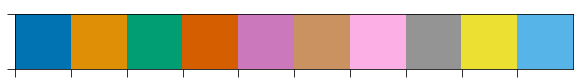

In [2]:
sns.palplot(sns.color_palette('colorblind'))

In [3]:
def read_hit_file(filename):
    text_file = open(filename, 'r')
    
    lines = text_file.readlines()
    hits = []
    for line in lines:
        if line.startswith('==='):
            continue
        if line.startswith('---'):
            hits.append([])
        if line.startswith('PixelHit'):
            line = line.rstrip().split()
            line = line[1:]
            for i in range(len(line)):
                line[i] = line[i].replace(',', '')
                line[i] = float(line[i])
            hits[-1].append(line)
    xhits, yhits, charge = [], [], []
    for i in range(len(hits)):
        #print(hits)
        hits[i] = tuple(zip(*hits[i]))
        xhits.append(hits[i][0])
        yhits.append(hits[i][1])
        charge.append(hits[i][2])
    return xhits, yhits, charge

In [4]:
def track_length(x, y):
    x_dist_sq = np.power(np.max(x) - np.min(x),2.)
    y_dist_sq = np.power(np.max(y) - np.min(y),2.)
    return np.power(x_dist_sq + y_dist_sq, 0.5)

def get_dEdx(M, E, Z):
    coeff = 2.32 * 14. / 28.0855 * 0.307
    meev = .511
    gamma = E  / M  + 1 
    beta = np.sqrt(1 - (1 / gamma**2))
    beta2gamma2 = (beta * gamma) **2 
    Tmax = (2 * meev  * beta2gamma2) / (1 + 2 * gamma * meev / M + (meev / M) ** 2)
    I = 10*14.0e-6
    hw = np.sqrt(2.32 * 14 / 28.0855) * 28.816e-6
    ln = np.log((2 * meev * beta2gamma2 * Tmax) / I**2)
    delta_over_2 = np.log(hw / I) + np.log(np.sqrt(beta2gamma2)) - 0.5
    
    return coeff * Z**2 / beta ** 2 * (0.5 * ln - beta ** 2 - delta_over_2)

me = .511
E_array = np.logspace(-2., 4., 100) 
muon_BB, electron_BB = [], []

for E in E_array:
    muon_BB.append(get_dEdx(206.7 * me, E, 1.))
    electron_BB.append(get_dEdx(me, E, 1.))

muon_BB = np.array(muon_BB)
muon_BB = muon_BB * (1./3.6) * 0.9 *1e2      # convert from MeV / cm to electron charge per pixel
electron_BB = np.array(electron_BB)
electron_BB = electron_BB * (1./3.6) * 0.9 *1e2     

In [7]:
col_names =  ['Energy', 'Theta (degrees)', 'Phi', 'Track Length (pixels)']
df  = pd.DataFrame(columns = col_names)

ens = ['10keV', '31.6keV', '100keV', '316keV', '1MeV', '3.16MeV', 
       '10MeV', '31.6MeV', '100MeV', '316MeV', '1GeV', '3.16GeV', '10GeV']

angles = ['0', '15', '30', '45', '60', '75']

counter = 0
for i, en in enumerate(['100MeV', '10GeV']):
    for j, ang in enumerate(angles):
        x, y, c = read_hit_file("/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/{}_theta_{}_phi_30.txt".format(en, ang))
        try:
            for i in range(len(x)):
                length = track_length(x[i], y[i])
                if length > 250:
                    continue
                df.loc[counter] = [en, ang, '30', length]
                counter += 1
        except:
            continue

In [8]:
## SIDE BY SIDE VIOLIN PLOT, ONE FOR 100MEV AND ONE FOR 10GEV FOR DIFFERENT ANGLES

/anaconda2/envs/pyth3env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


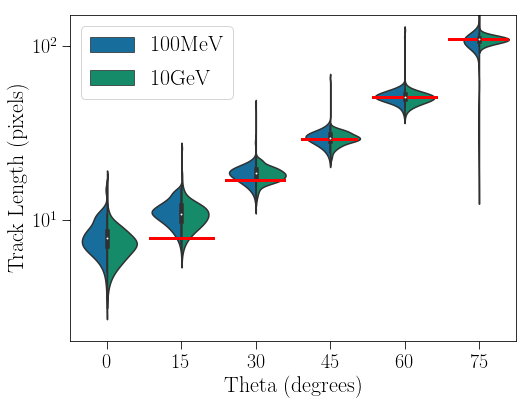

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

my_pal = {'100MeV': sns.color_palette('colorblind')[0], 
         '10GeV': sns.color_palette('colorblind')[2]}

sns.violinplot(x="Theta (degrees)", y="Track Length (pixels)", hue="Energy",
                    data=df, palette=my_pal, 
               split=True)

plt.axhline(0. , c = 'r', xmin = 0.03, xmax = 0.14, lw=3)
plt.axhline((26.3/0.9) * np.tan(15. * np.pi / 180.), c = 'r', xmin = 0.18, xmax = 0.32, lw=3)
plt.axhline((26.3/0.9) * np.tan(30. * np.pi / 180.), c = 'r', xmin = 0.35, xmax = 0.48, lw=3)
plt.axhline((26.3/0.9) * np.tan(45. * np.pi / 180.), c = 'r', xmin = 0.52, xmax = 0.64, lw=3)
plt.axhline((26.3/0.9) * np.tan(60. * np.pi / 180.), c = 'r', xmin = 0.68, xmax = 0.82, lw=3)
plt.axhline((26.3/0.9) * np.tan(75. * np.pi / 180.), c = 'r', xmin = 0.85, xmax = 0.98, lw=3)

plt.legend(loc=2)
plt.ylim(2, 150.)
plt.yscale('symlog')
plt.show()

In [20]:
col_names =  ['Energy', 'Theta (degrees)', 'Phi', 'Deposited Charge ($N_{e^{-}}$)']
df_charge  = pd.DataFrame(columns = col_names)

ens = ['10keV', '31.6keV', '100keV', '316keV', '1MeV', '3.16MeV', 
       '10MeV', '31.6MeV', '100MeV', '316MeV', '1GeV', '3.16GeV', '10GeV']

angles = ['0', '15', '30', '45', '60', '75']

counter = 0
for i, en in enumerate(['100MeV', '10GeV']):
    for j, ang in enumerate(angles):
        x, y, c = read_hit_file("/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/{}_theta_{}_phi_30.txt".format(en, ang))
        try:
            for i in range(len(x)):
                charge = np.sum(c[i])
                #if charge > 30000:
                #    continue
                df_charge.loc[counter] = [en, ang, '30', charge]
                counter += 1
        except:
            continue

/anaconda2/envs/pyth3env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


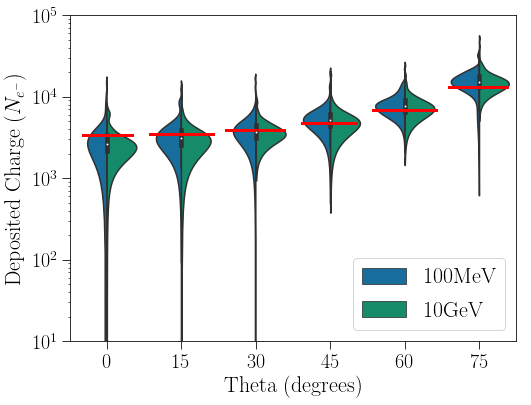

In [21]:
fig, ax = plt.subplots(figsize = (8,6))

sns.violinplot(x="Theta (degrees)", y='Deposited Charge ($N_{e^{-}}$)', hue='Energy',
                    data=df_charge, palette=my_pal, split=True)

plt.axhline(3386, c = 'r', xmin = 0.03, xmax = 0.14, lw=3)
plt.axhline(3386 / np.cos(15. * np.pi / 180.), c = 'r', xmin = 0.18, xmax = 0.32, lw=3)
plt.axhline(3386 / np.cos(30. * np.pi / 180.), c = 'r', xmin = 0.35, xmax = 0.48, lw=3)
plt.axhline(3386 / np.cos(45. * np.pi / 180.), c = 'r', xmin = 0.52, xmax = 0.64, lw=3)
plt.axhline(3386 / np.cos(60. * np.pi / 180.), c = 'r', xmin = 0.68, xmax = 0.82, lw=3)
plt.axhline(3386 / np.cos(75. * np.pi / 180.), c = 'r', xmin = 0.85, xmax = 0.98, lw=3)


plt.legend(loc=4)
plt.ylim(1e1, 1e5)
plt.yscale('log')
plt.show()

In [22]:
col_names =  ['Energy', 'Theta (degrees)', 'Phi', 'Deposited Charge ($N_{e^{-}}$)', 
              'Energy (GeV)', 'Track Length (pixels)', 'Charge per unit length']
df_energies  = pd.DataFrame(columns = col_names)

ens = ['10keV', '31.6keV', '100keV', '316keV', '1MeV', '3.16MeV', 
       '10MeV', '31.6MeV', '100MeV', '316MeV', '1GeV', '3.16GeV', '10GeV']
en_float = np.logspace(-2., 4, 13)

angles = ['0', '15', '30', '45', '60', '75']

counter = 0
for i, en in enumerate(ens):
    for k, ang in enumerate(angles):
        x, y, c = read_hit_file("/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/{}_theta_{}_phi_30.txt".format(en, ang))    
        try:
            for j in range(len(x)):
                charge = np.sum(c[j])
                length = track_length(x[j], y[j])
                dE_dX = charge / np.power(length**2 + (26.3 / 0.9)**2, 0.5)
                df_energies.loc[counter] = [en, ang, '30', charge, en_float[i], length, dE_dX]
                counter += 1
        except:
            continue

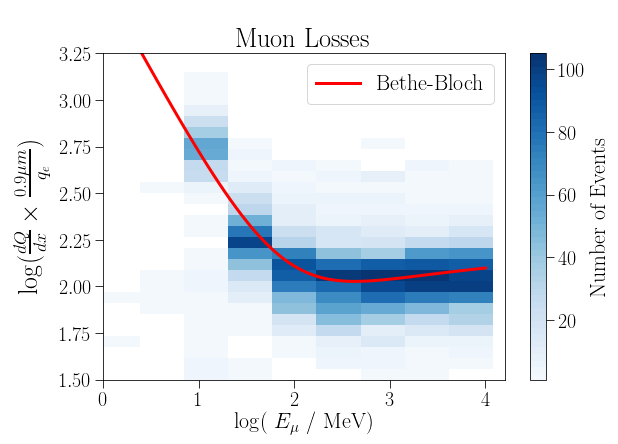

In [13]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize = (9, 6))

my_cmap = ListedColormap(sns.color_palette("Blues", 50))
fig.set_facecolor('white')

h = plt.hist2d(np.log10(df_energies['Energy (GeV)']), np.log10(df_energies['Charge per unit length']),
           bins = [np.linspace(-1., 5., 14), np.linspace(1.5, 3.5, 35)], cmin = 1., cmap = my_cmap
          )
plt.colorbar(label = "Number of Events")
plt.title("Muon Losses")
plt.plot(np.log10(E_array), np.log10(muon_BB) , c = 'r', label = "Bethe-Bloch", lw=3)
plt.ylabel(r'$\log (\frac{dQ}{dx} \times \frac{0.9 \mu m}{q_{e}})$', fontsize = 26)
plt.xlabel('$\log$( $E_{\mu}$ / MeV) ')
plt.legend(loc = 1)
plt.xlim(0, 4.2)
plt.ylim(1.5, 3.25)
plt.show()

In [80]:
#x, y, c = read_hit_file("/Users/APizzuto/Desktop/DECO_geant/htc_wildfire/output/images/mu+_100MeV_theta_75_phi_30.txt") 

file_list = glob('/Users/APizzuto/Desktop/DECO_geant/htc_wildfire/output/gamma/100keV*.txt')
x, y, c = read_hit_file(


/Users/APizzuto/Desktop/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_75_phi_30_highstats.txt


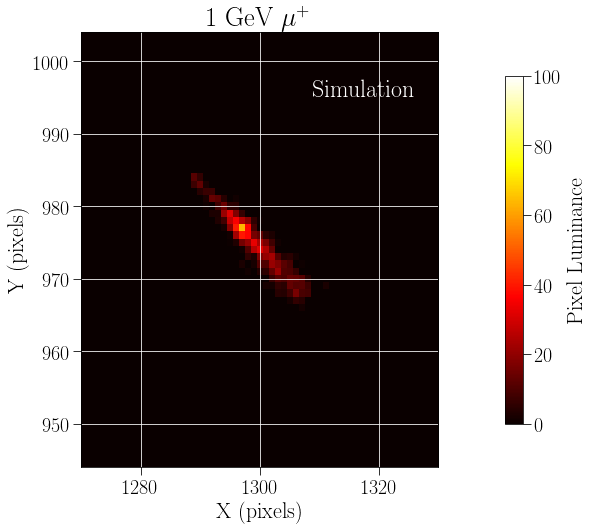

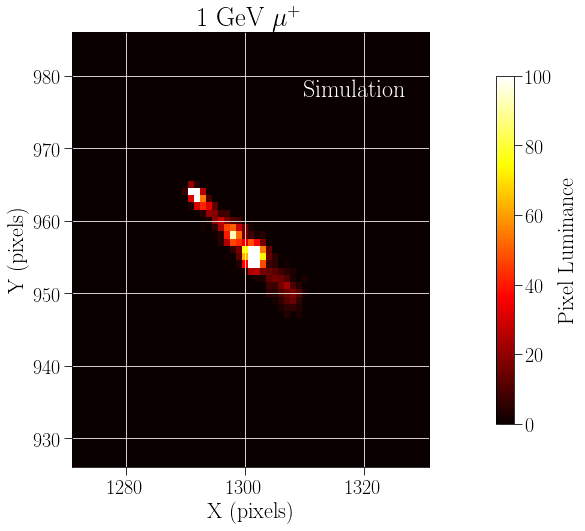

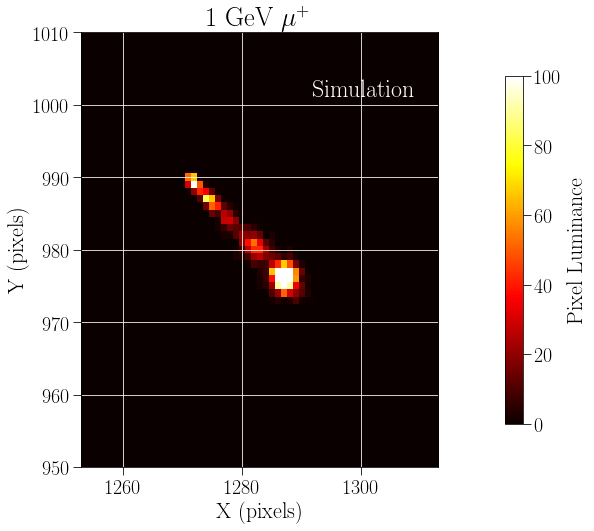

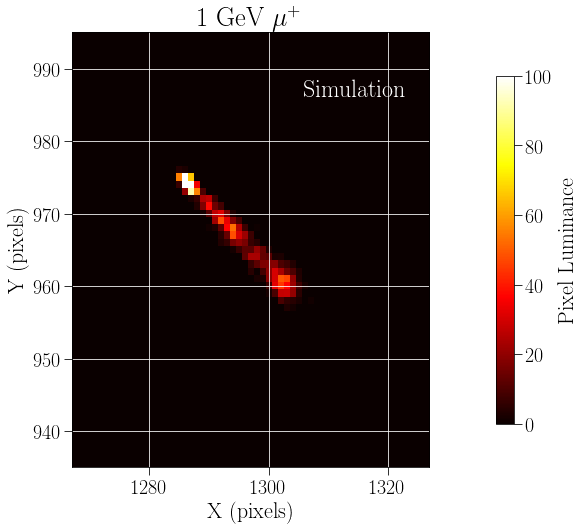

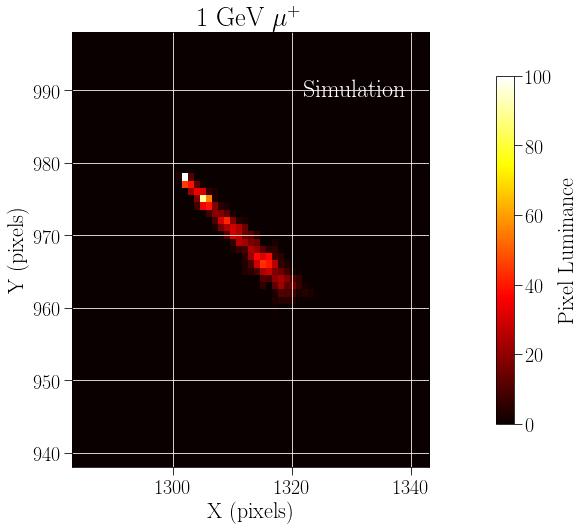

In [86]:
#file_list = glob('/Users/APizzuto/Desktop/DECO_geant/htc_wildfire/output/gamma/1MeV*.txt')
file_list = glob('/Users/APizzuto/Desktop/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_75_*.txt')
sqrt = False

for k in range(2,len(file_list)):
    x, y, c = read_hit_file(file_list[k])
    print(file_list[k])
    for j in range(5):
        #try:
        image = np.zeros((4500, 4500))
        for i in range(len(x[j])):
            image[int(y[j][i]), int(x[j][i])] = c[j][i]
        
        if sqrt:
            image = np.sqrt(image)    
        
        med_x = np.median(x[j])
        med_y = np.median(y[j])
        size = 30.    

        title = "1 GeV $\mu^{+}$"
        fig1 = plt.figure(1, figsize=(8,8))
        ax = fig1.add_subplot(111)
        fig1.set_facecolor('white')

        #my_cmap = ListedColormap(sns.color_palette("Blues", 50))
        #my_cmap = ListedColormap(sns.palplot(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)))
        my_cmap = mpl.cm.hot
        
        #image = np.where(image == 0.0, np.nan, image)

        im = ax.imshow(image, cmap=my_cmap, #interpolation="gaussian", 
                       aspect="auto", vmax=100., vmin = 0.0)
        ax.set_xlim([med_x - size, med_x + size])
        ax.set_ylim([med_y - size, med_y + size])
        ax.set_xlabel("X (pixels)")
        ax.set_ylabel("Y (pixels)")
        ax.set_title(title)

        ax.grid(color="#ffffff")
        cb = fig1.colorbar(im, orientation="vertical",
                               shrink=0.8,
                               fraction=0.05,
                               pad=0.15)
        label = "Pixel Luminance"
        cb.set_label(label)
        ax.text(med_x + size * 0.3,med_y + size * 0.7, 
                "Simulation", fontsize = 24, color = 'w', weight = 'heavy')
        plt.show()
        #except e:
        #    print(e)
        #    continue


In [13]:
file_list = glob('/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_*.txt')
file_list

['/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_75_phi_0.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_75_phi_30.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_0_phi_30.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_15_phi_30.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_60_phi_0.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_30_phi_0.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_0_phi_0.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_45_phi_30.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_60_phi_30.txt',
 '/Users/APizzuto/Desktop/Research/DECO_geant/htc_wildfire/output/mu+/1GeV_theta_30_phi_30.txt',
 '/Users/APizzuto/Desktop/Research/D

In [44]:
?plt.text

In [17]:
?ax.imshow()

In [282]:
x, y, c = read_hit_file("/Users/APizzuto/Desktop/DECO_geant/DECO_allpix/source_shielding/output/images/e-_10MeV_theta_120_phi_30.txt") 


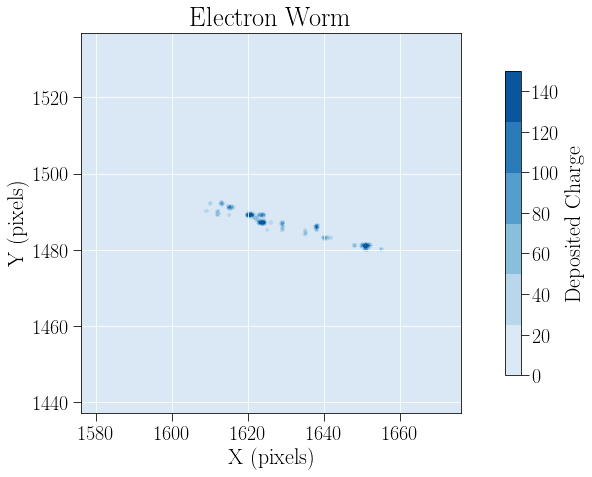

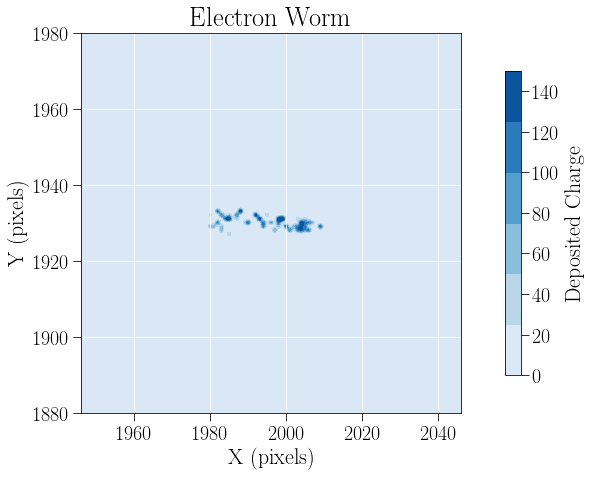

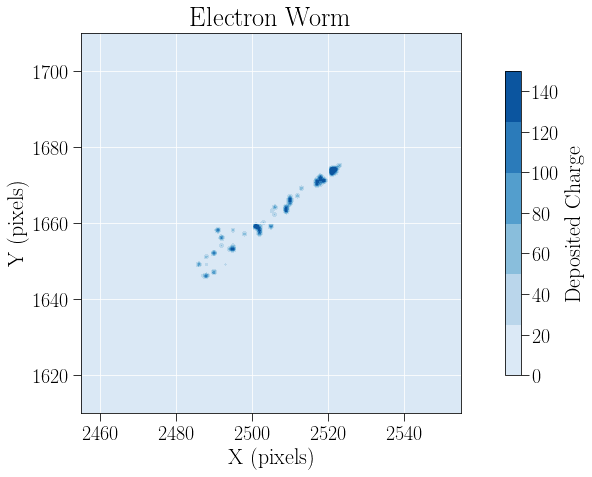

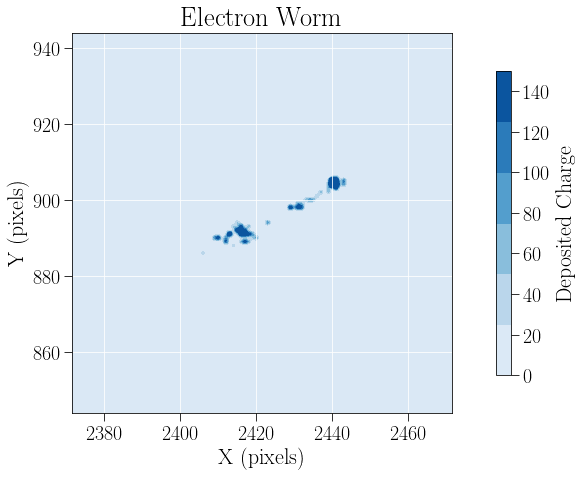

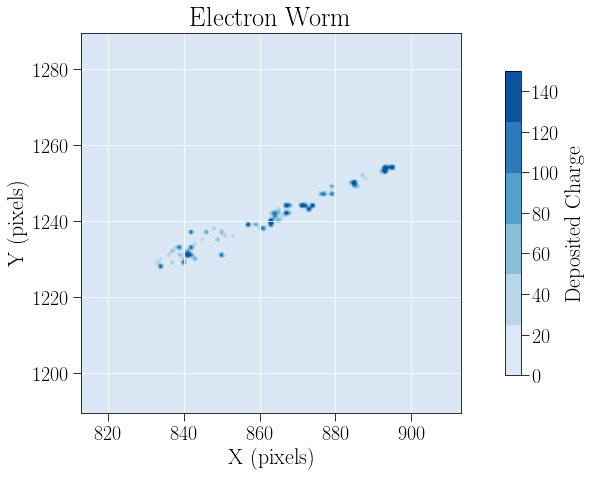

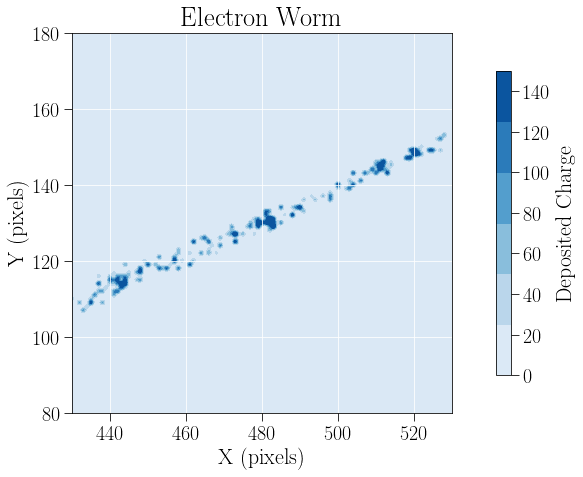

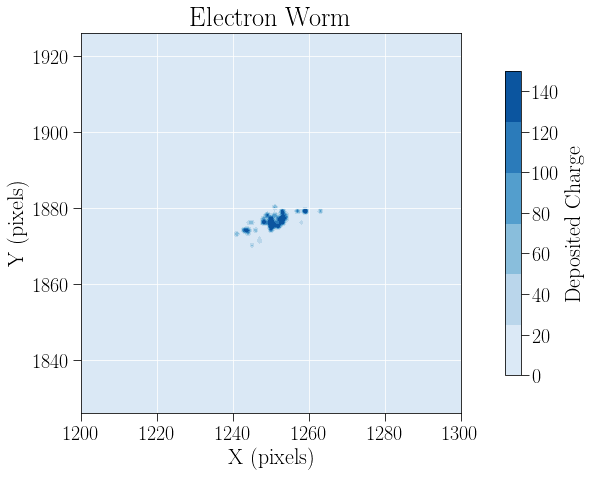

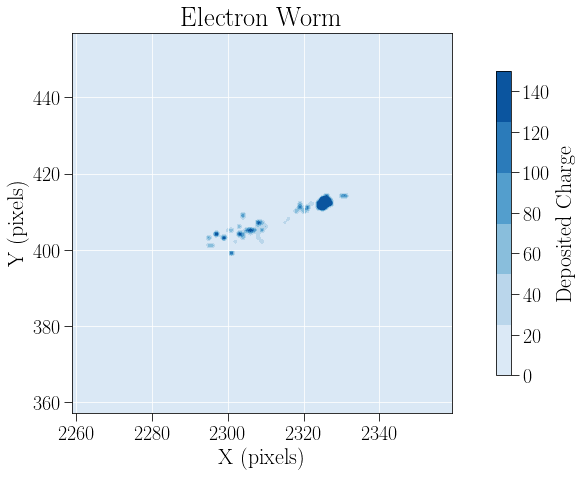

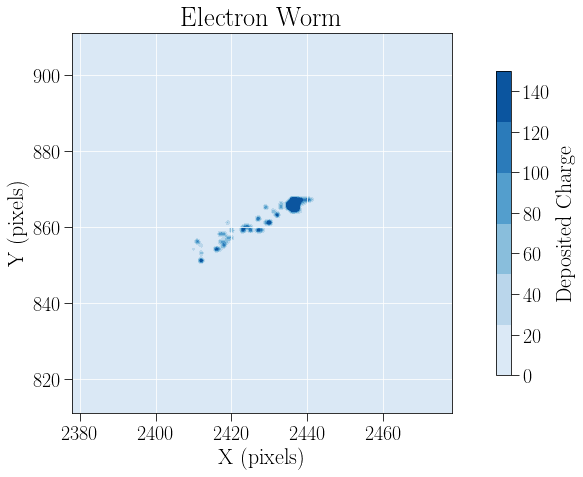

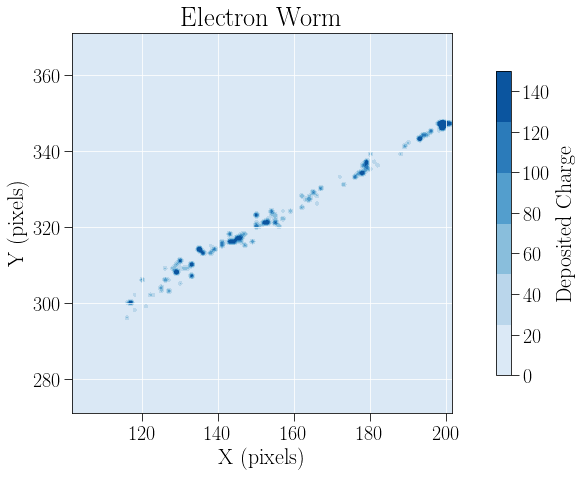

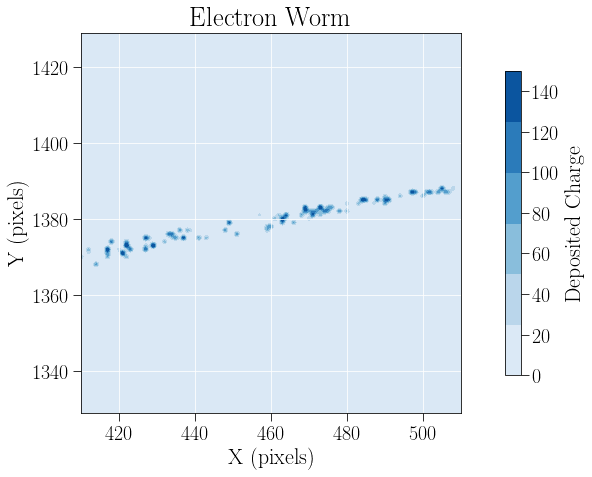

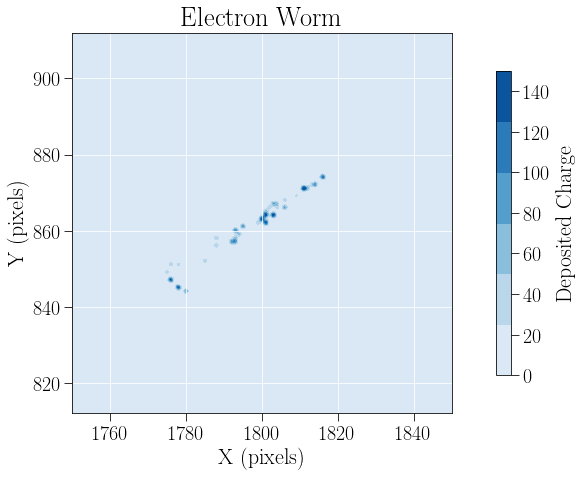

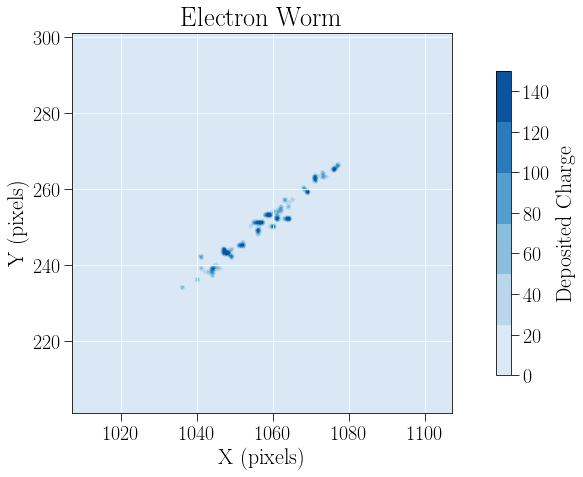

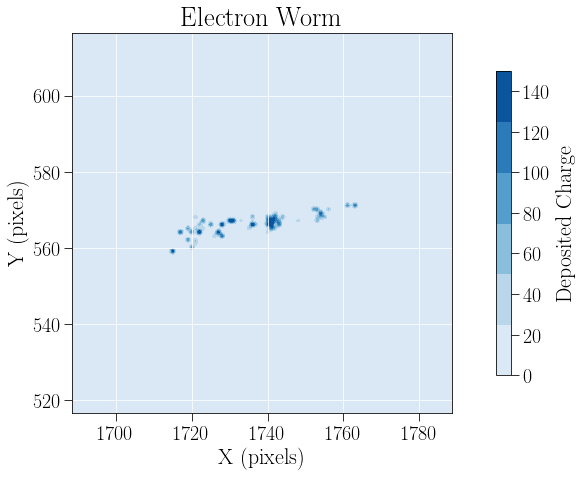

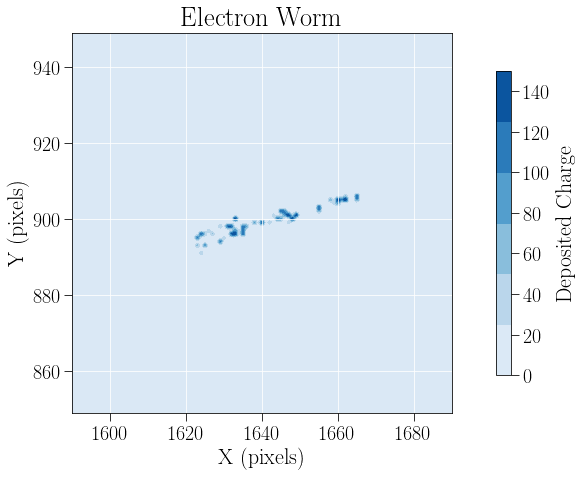

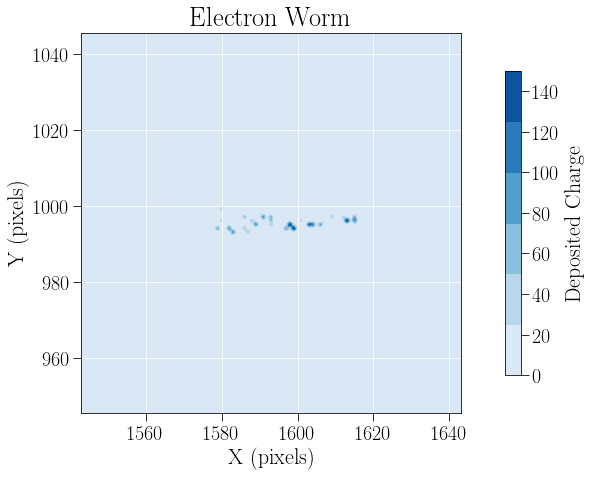

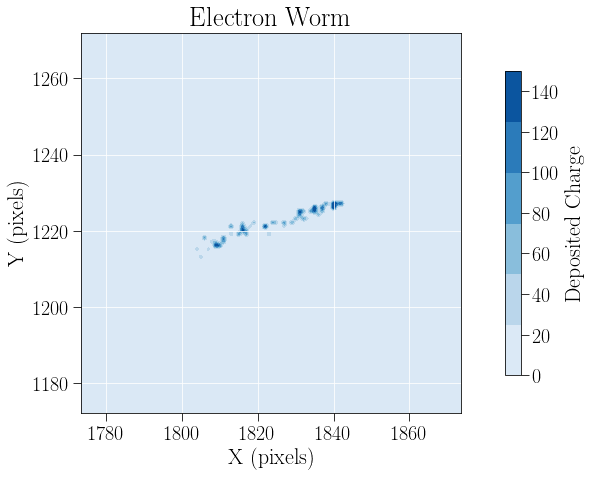

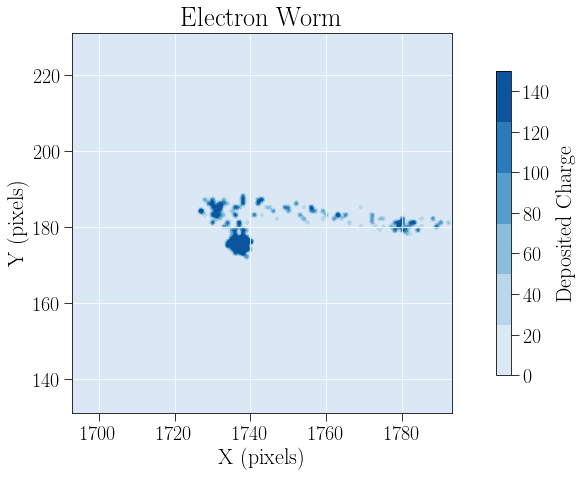

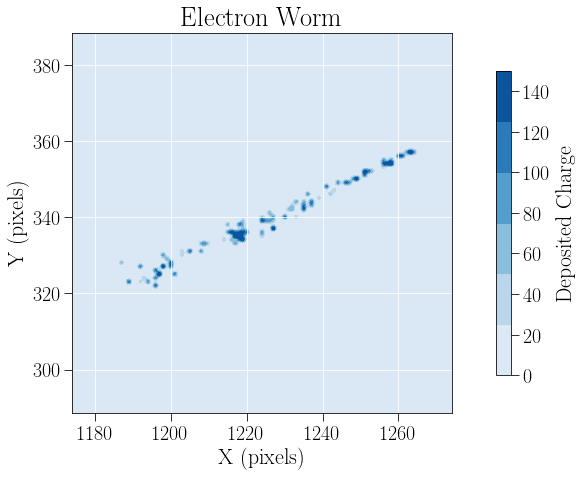

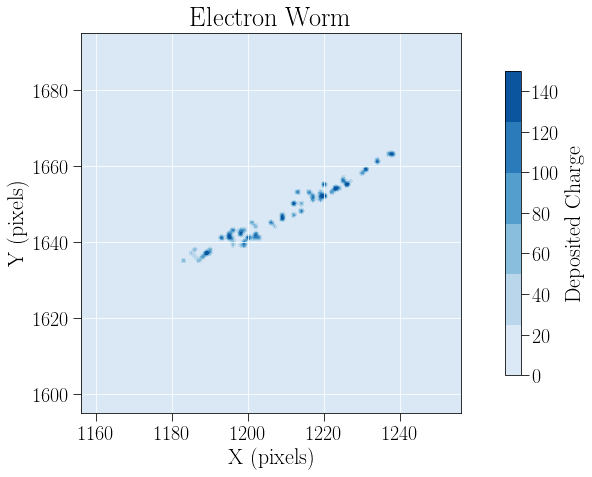

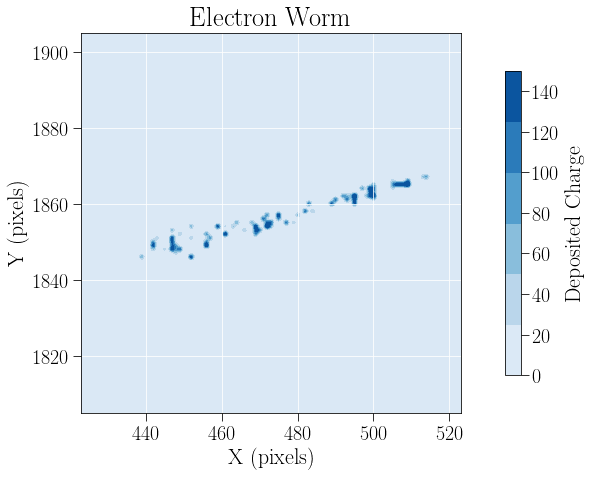

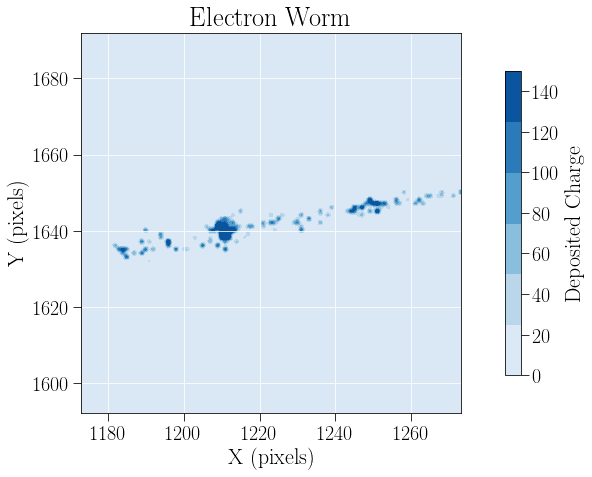

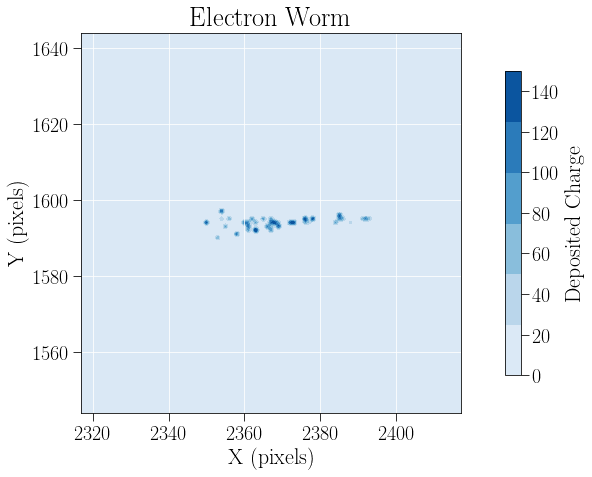

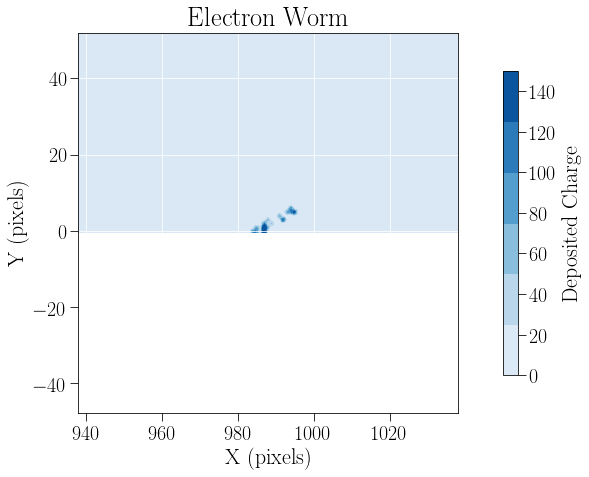

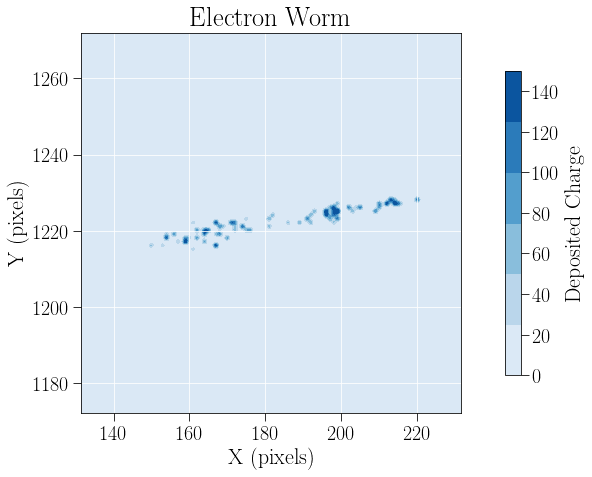

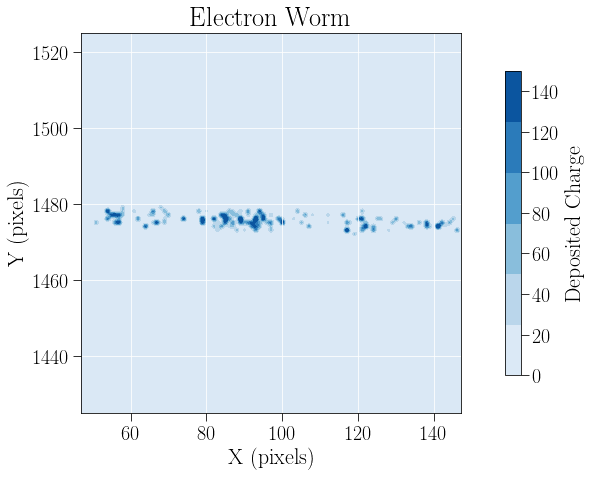

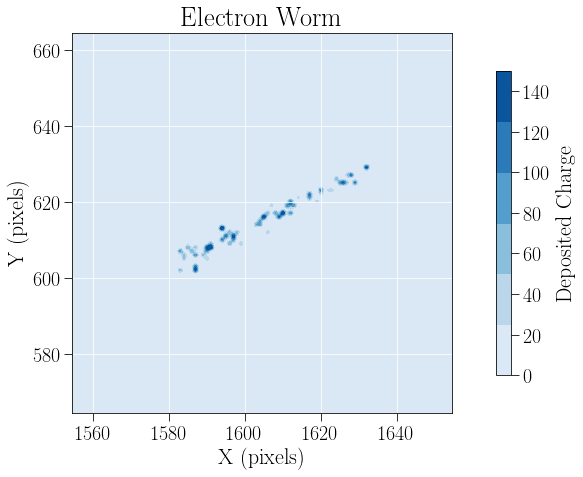

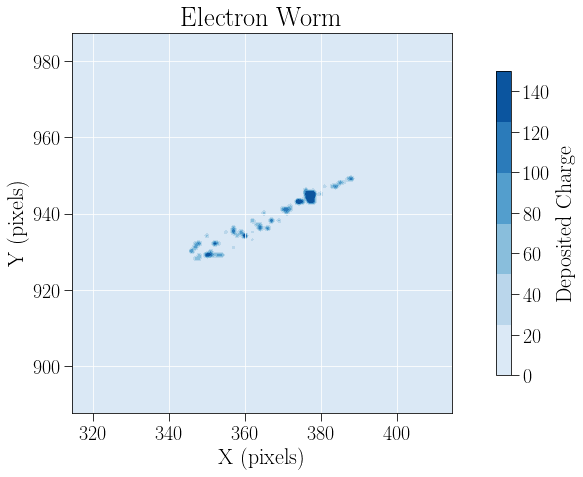

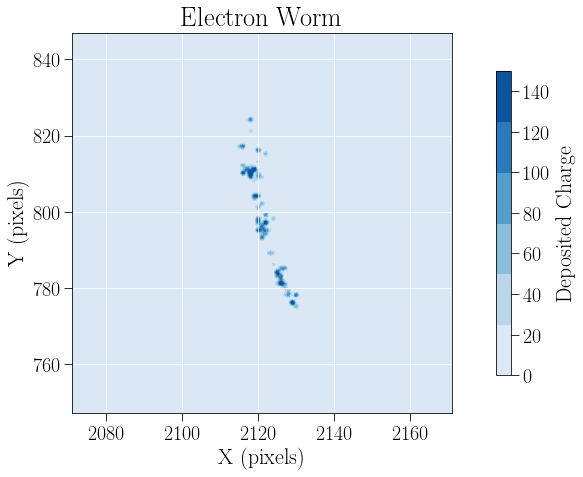

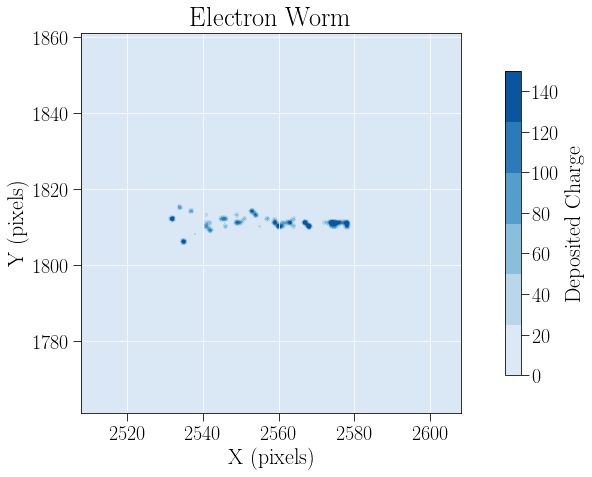

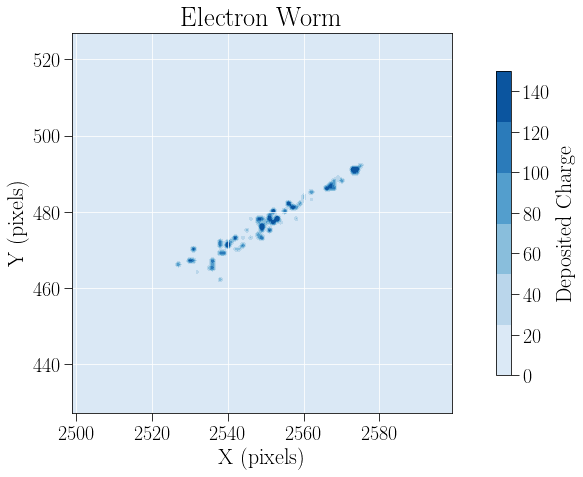

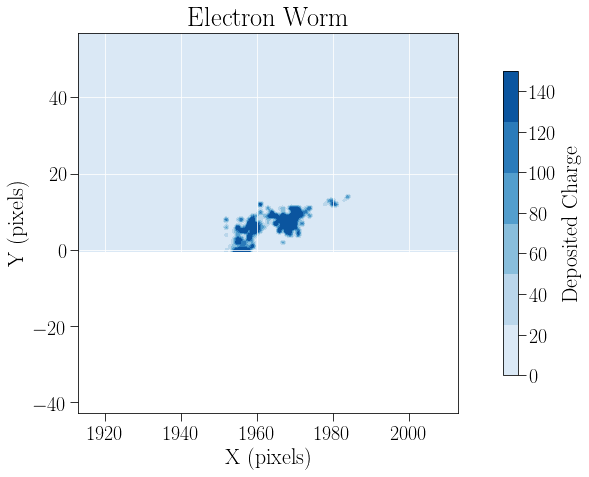

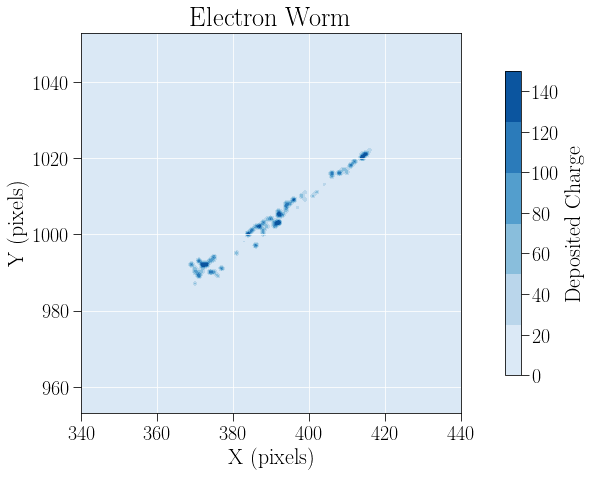

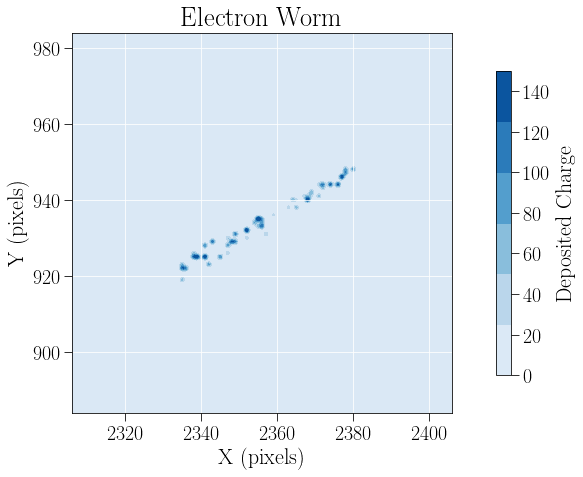

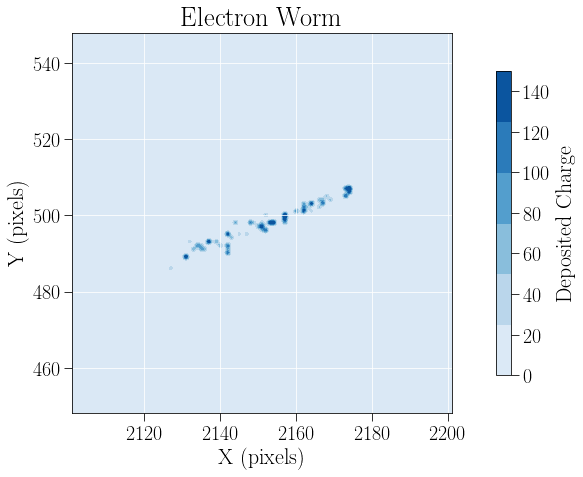

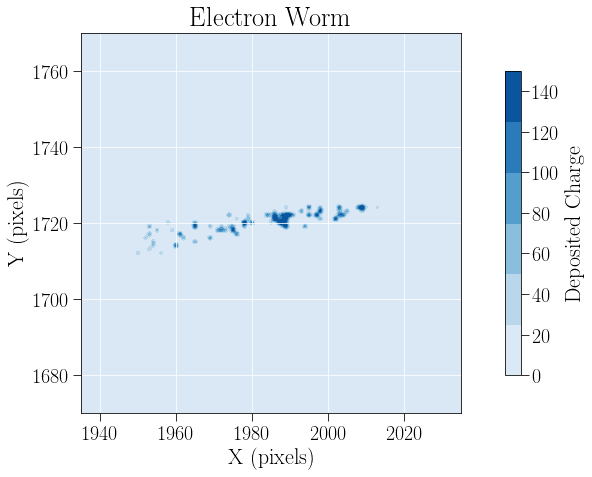

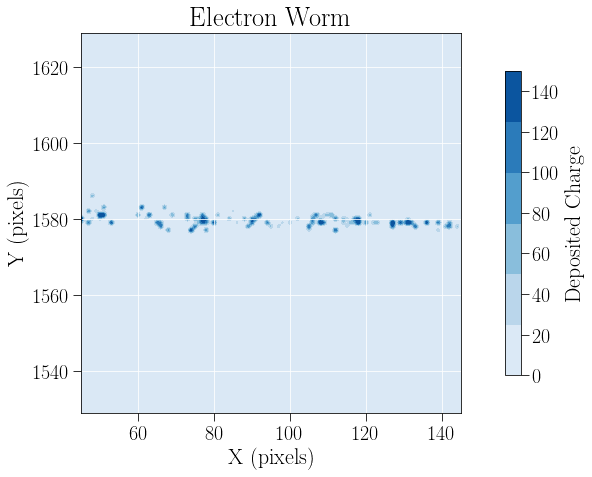

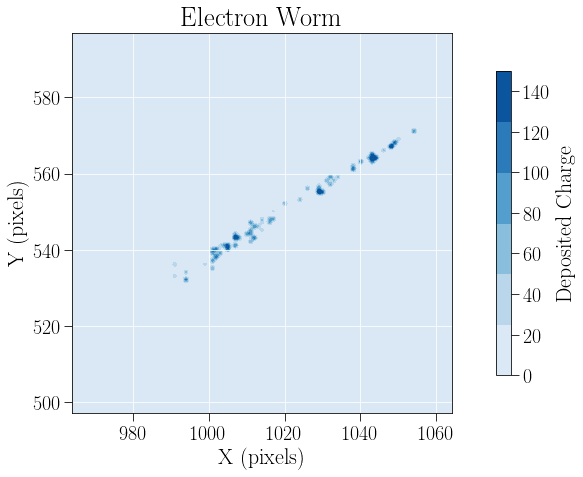

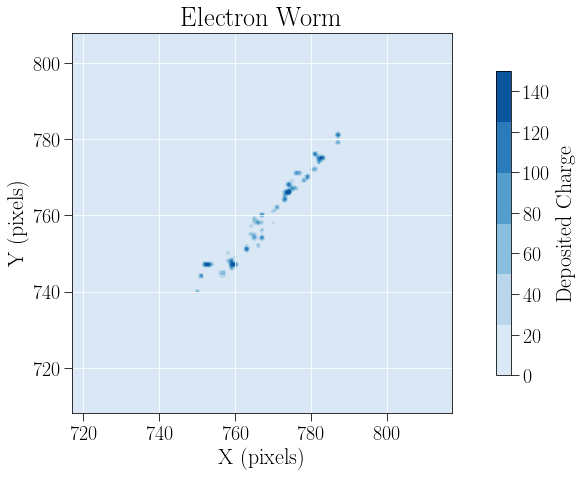

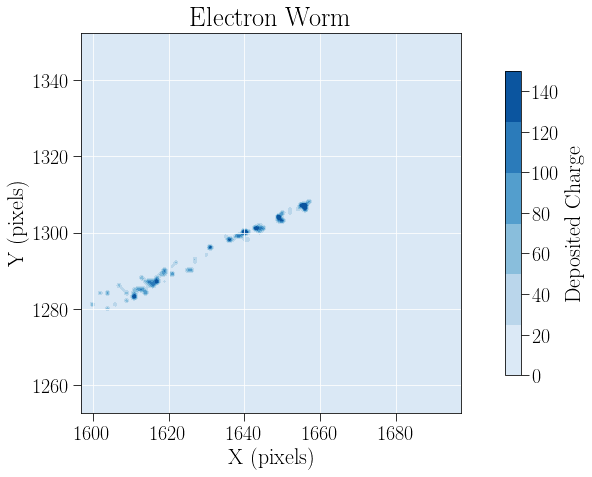

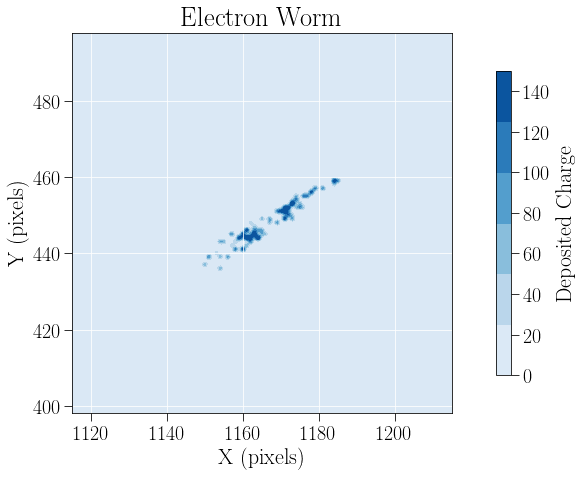

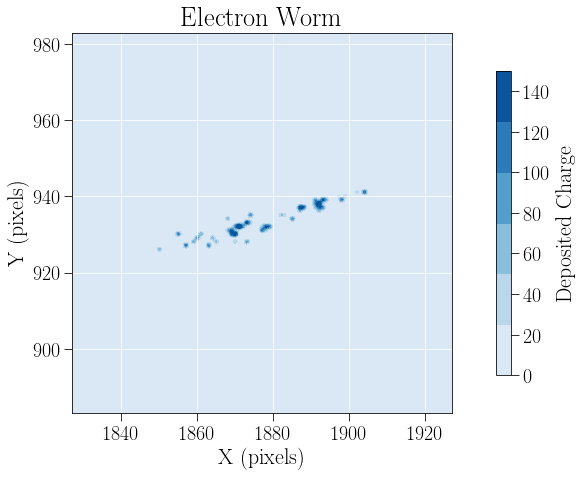

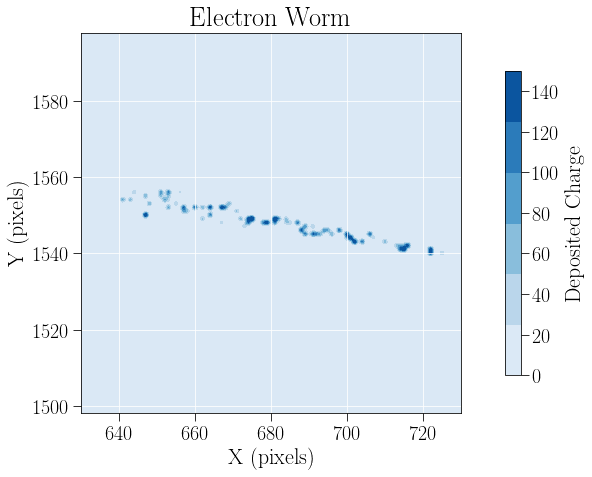

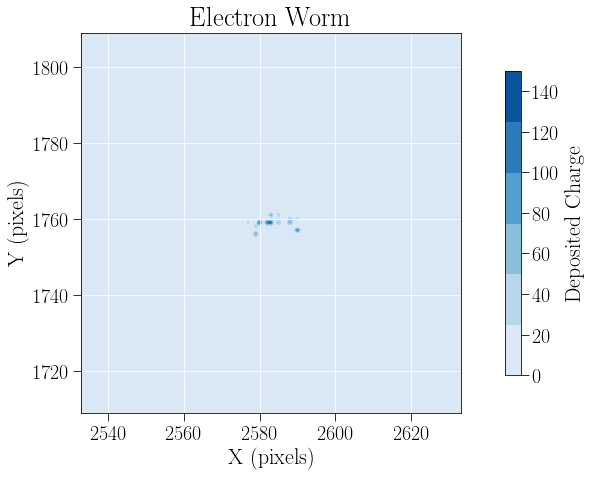

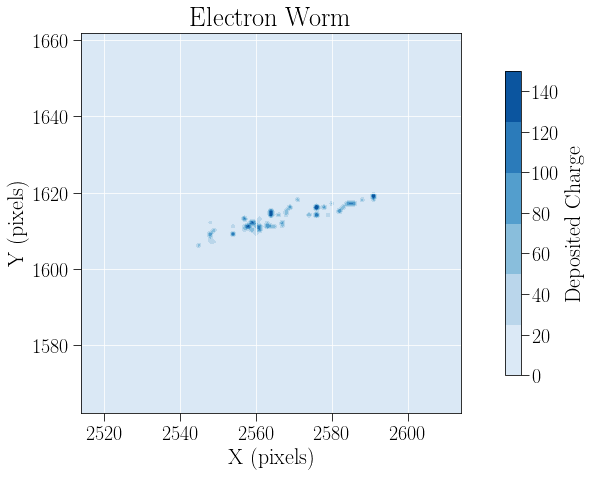

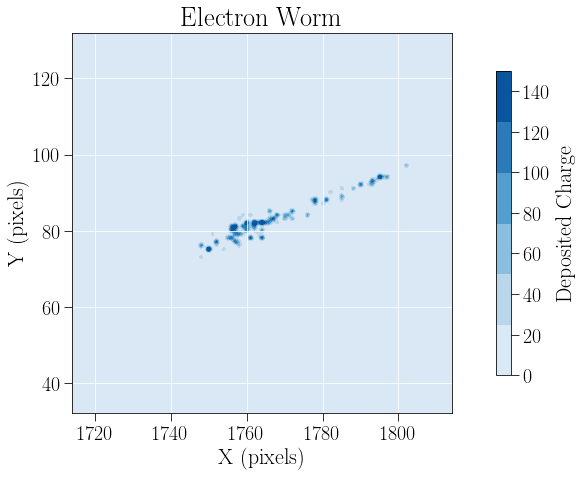

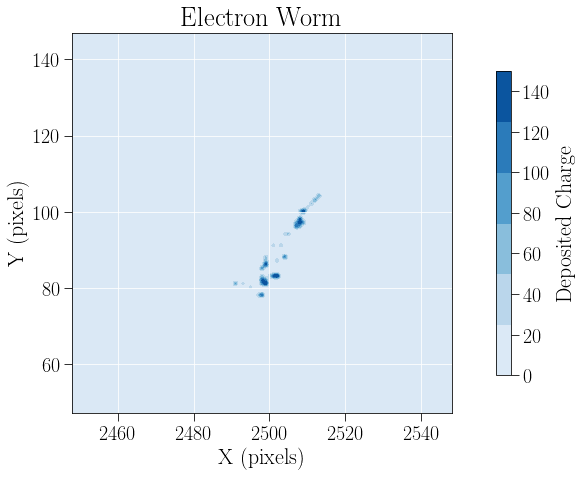

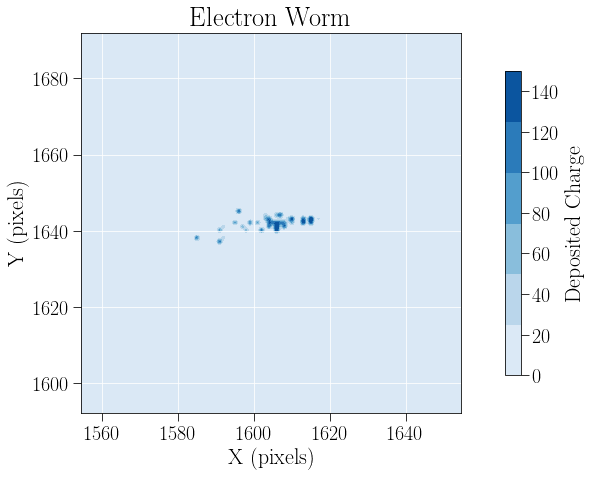

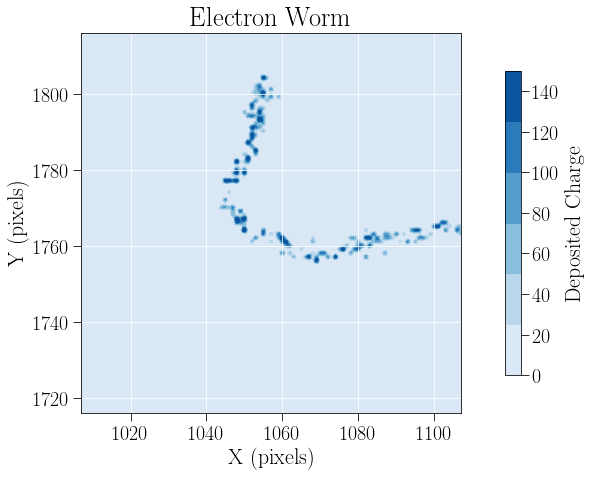

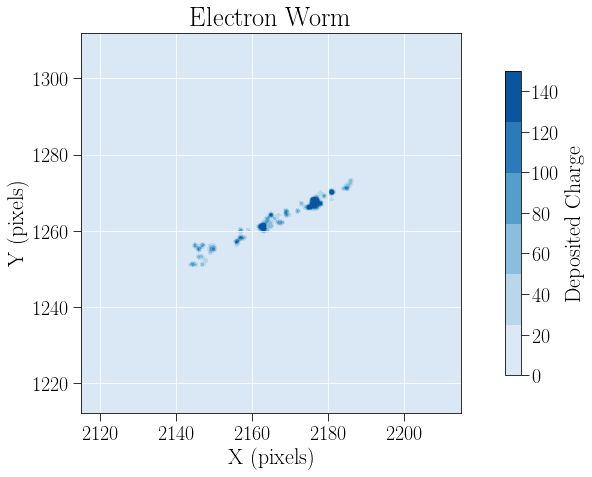

In [283]:
for j in range(50):

    image = np.zeros((3000, 3000))
    for i in range(len(x[j])):
        image[int(y[j][i]), int(x[j][i])] = c[j][i]
    
    med_x = np.median(x[j])
    med_y = np.median(y[j])
    size = 50.
    
    title = "Electron Worm"
    fig1 = plt.figure(1, figsize=(8,7))
    ax = fig1.add_subplot(111)

    my_cmap = ListedColormap(sns.color_palette("Blues"))
    #my_cmap = ListedColormap(sns.palplot(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)))
    #my_cmap = mpl.cm.hot

    im = ax.imshow(image, cmap=my_cmap, interpolation="gaussian", aspect="auto", vmax=150.)
    ax.set_xlim([med_x - size, med_x + size])
    ax.set_ylim([med_y - size, med_y + size])
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")
    ax.set_title(title)

    ax.grid(color="#ffffff")
    cb = fig1.colorbar(im, orientation="vertical",
                           shrink=0.8,
                           fraction=0.05,
                           pad=0.1)
    label = "Deposited Charge"
    cb.set_label(label)
    plt.show()


In [296]:
x, y, c = read_hit_file("/Users/APizzuto/Desktop/DECO_geant/DECO_allpix/source_shielding/output/images/gamma_316keV_theta_60_phi_30.txt") 

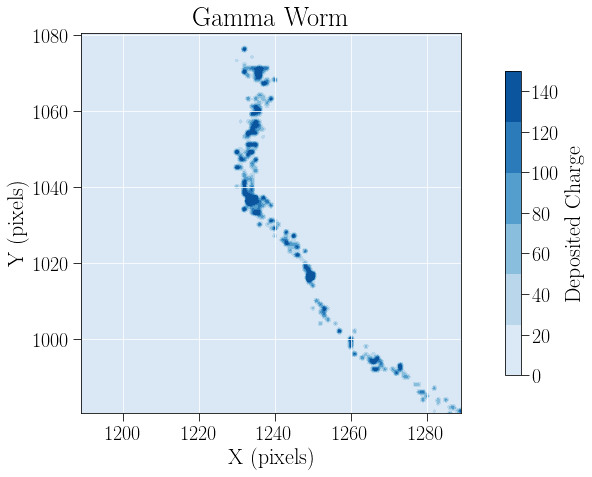

IndexError: list index out of range

In [298]:
for j in range(50):

    image = np.zeros((3000, 3000))
    for i in range(len(x[j])):
        image[int(y[j][i]), int(x[j][i])] = c[j][i]
    
    med_x = np.median(x[j])
    med_y = np.median(y[j])
    size = 50.
    
    title = "Gamma Worm"
    fig1 = plt.figure(1, figsize=(8,7))
    ax = fig1.add_subplot(111)

    my_cmap = ListedColormap(sns.color_palette("Blues"))
    #my_cmap = ListedColormap(sns.palplot(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)))
    #my_cmap = mpl.cm.hot

    im = ax.imshow(image, cmap=my_cmap, interpolation="gaussian", aspect="auto", vmax=150.)
    ax.set_xlim([med_x - size, med_x + size])
    ax.set_ylim([med_y - size, med_y + size])
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")
    ax.set_title(title)

    ax.grid(color="#ffffff")
    cb = fig1.colorbar(im, orientation="vertical",
                           shrink=0.8,
                           fraction=0.05,
                           pad=0.1)
    label = "Deposited Charge"
    cb.set_label(label)
    plt.show()


In [21]:
col_names =  ['Energy', 'Theta (degrees)', 'Phi', 'Deposited Charge ($N_{e^{-}}$)', 
              'Energy (GeV)', 'Track Length (pixels)', 'Charge per unit length']
df_energies  = pd.DataFrame(columns = col_names)

ens = ['10keV', '31.6keV', '100keV', '316keV', '1MeV', '3.16MeV', 
       '10MeV', '31.6MeV', '100MeV', '316MeV', '1GeV', '3.16GeV', '10GeV']
en_float = np.logspace(-2., 4, 13)

angles = ['0', '15', '30', '45', '60', '75']

counter = 0
for i, en in enumerate(ens):
    for k, ang in enumerate(angles):
        try:
            x, y, c = read_hit_file("/Users/APizzuto/Desktop/DECO_geant/htc_wildfire/output/e-/{}_theta_{}_phi_30_highstats.txt".format(en, ang))    
            try:
                for j in range(len(x)):
                    charge = np.sum(c[j])
                    length = track_length(x[j], y[j])
                    dE_dX = charge / np.power(length**2 + (26.3 / 0.9)**2, 0.5)
                    df_energies.loc[counter] = [en, ang, '30', charge, en_float[i], length, dE_dX]
                    counter += 1
            except:
                continue
        except:
            continue

In [22]:
df_energies.shape

(27211, 7)

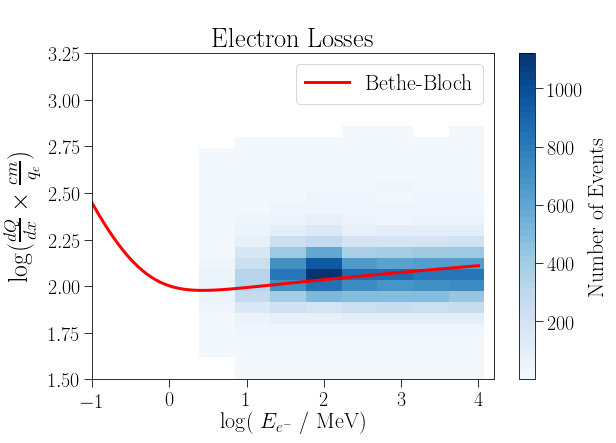

In [23]:
fig, ax = plt.subplots(figsize = (9, 6))

my_cmap = ListedColormap(sns.color_palette("Blues", 50))

h = plt.hist2d(np.log10(df_energies['Energy (GeV)']), np.log10(df_energies['Charge per unit length']),
           bins = [np.linspace(-1., 5., 14), np.linspace(1.5, 3.5, 35)], cmin = 1., cmap = my_cmap
          )
plt.colorbar(label = "Number of Events")
plt.title("Electron Losses")
plt.plot(np.log10(E_array), np.log10(electron_BB) , c = 'r', label = "Bethe-Bloch", lw = 3)
plt.ylabel(r'$\log (\frac{dQ}{dx} \times \frac{cm}{q_{e}})$', fontsize = 26)
plt.xlabel('$\log$( $E_{e^{-}}$ / MeV) ')
plt.legend(loc = 1)
plt.xlim(-1., 4.2)
plt.ylim(1.5, 3.25)
plt.show()